<a href="https://colab.research.google.com/github/Tsung-Hung/dummy-git/blob/master/0505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import cv2
import numpy as np
import imageio.v2 as imageio
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
!pip install rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00


tensor(0.) tensor(0.9998)


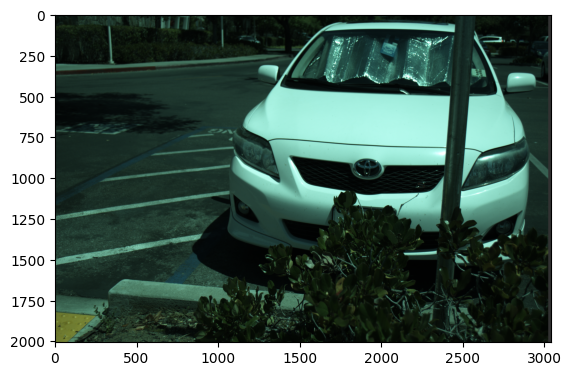

In [ ]:
import rawpy

def extract_bayer_channels(raw):

    # Reshape the input bayer image
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[0::2, 1::2]
    ch_Gb = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]

    RAW_combined = np.dstack((ch_R, ch_Gr, ch_Gb, ch_B))
    RAW_norm = RAW_combined.astype(np.float32) / 2**12

    return RAW_norm

########## VISUALIZATION

def demosaic(raw):
    
    shape = raw.shape
    
    red  = raw[0,:,:]
    green_red  = raw[1,:,:]
    green_blue = raw[2,:,:]
    blue  = raw[3,:,:]
    avg_green  = (green_red + green_blue) / 2
    image  = np.stack((red, avg_green, blue), axis=0)
    return image

def gamma_compression(image):
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def unpack(raw):

    out = np.zeros((raw.shape[0] * 2, raw.shape[1] * 2))  
    out[0::2, 0::2] = raw[:, :, 0]
    out[0::2, 1::2] = raw[:, :, 1]
    out[1::2, 0::2] = raw[:, :, 2]
    out[1::2, 1::2] = raw[:, :, 3]
    
    out = out * (2 ** 12)
    out = out.astype(np.uint16)
    return out

data_raw_path = '/content/2014_000001.nef'
image_raw = rawpy.imread(data_raw_path)
# image_raw.color_desc  "RGBG"
image_raw = image_raw.raw_image
image_raw = extract_bayer_channels(image_raw)
# image_raw = cv2.resize(image_raw, (300, 200))
image_raw = torch.from_numpy(image_raw.transpose((2, 0, 1)))
data_post = postprocess_raw(demosaic(image_raw))

print(image_raw.min(), image_raw.max())
# visualization
data_visual = data_post.transpose((1, 2, 0)) 
plt.imshow(data_visual)

In [ ]:
data_raw_path = '/content/2014_000001.nef'
image_raw = rawpy.imread(data_raw_path)
image_raw.sizes

ImageSizes(raw_height=4012, raw_width=6080, height=4012, width=6034, top_margin=0, left_margin=0, iheight=4012, iwidth=6034, pixel_aspect=1.0, flip=0)

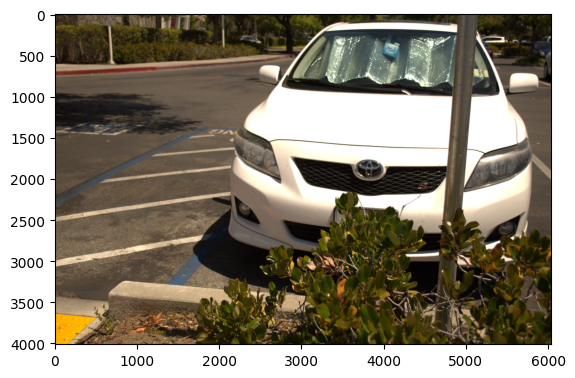

In [ ]:
img_rgb = image_raw.postprocess(use_camera_wb=True, no_auto_bright=True, exp_shift=2)
plt.imshow(img_rgb)

In [ ]:
import tempfile
from PIL import Image
import imageio.v2 as imageio

with rawpy.imread('/content/2014_000001.nef') as raw:
  raw_image = raw.raw_image.copy()
  raw_image = extract_bayer_channels(raw_image)

pil_image = Image.fromarray(raw_image)
resized_image = pil_image.resize((600, 400))

tempile_path = tempfile.NamedTemporaryFile(suffix='.tiff').name
imageio.imwrite(tempile_path, resized_image)

with rawpy.imread(tempile_path) as raw:
  process_image = raw.postprocess()

imageio.imwrite('example_process.jpg', process_image)

In [ ]:
with rawpy.imread('/content/2014_000001.nef') as raw:
  raw_image = raw.raw_image.copy()


x = int(raw_image.shape[0]/2)
y = int(raw_image.shape[1]/2)
raw_image = raw_image[x-2000:x+2000, y-3000:y+3000]

raw_image = extract_bayer_channels(raw_image)
print('raw_image: ', raw_image.shape)

pil_image = cv2.resize(raw_image, (300, 200))
pil_image = unpack(pil_image)
print('pil_image: ', pil_image.shape)

tempile_path = tempfile.NamedTemporaryFile(suffix='.tiff').name
imageio.imwrite(tempile_path, pil_image)

with rawpy.imread(tempile_path) as raw:
  print('raw: ', raw.sizes)
  process_image = raw.postprocess()
  print('process_image: ', process_image.shape)

imageio.imwrite('test.jpg', process_image)

raw_image:  (2000, 3000, 4)
pil_image:  (400, 600)
raw:  ImageSizes(raw_height=400, raw_width=600, height=400, width=600, top_margin=0, left_margin=0, iheight=400, iwidth=600, pixel_aspect=1.0, flip=0)
process_image:  (400, 600, 3)


In [ ]:
raw = rawpy.imread('/content/2014_000001.nef')
raw_image = raw.raw_image.copy()


x = int(raw_image.shape[0]/2)
y = int(raw_image.shape[1]/2)
raw_image = raw_image[x-2000:x+2000, y-3000:y+3000]

raw_image = extract_bayer_channels(raw_image)
print('raw_image: ', raw_image.shape)

pil_image = cv2.resize(raw_image, (300, 200))
pil_image = unpack(pil_image)
print('pil_image: ', pil_image.shape)
imageio.imsave('test_png.png', pil_image)

tempile_path = tempfile.NamedTemporaryFile(suffix='.tiff').name
imageio.imwrite(tempile_path, pil_image)

raw =  rawpy.imread(tempile_path)
print('raw: ', raw.sizes)
process_image = raw.postprocess()
print('process_image: ', process_image.shape)

imageio.imsave('test_jpg.jpg', process_image)

raw_image:  (2000, 3000, 4)
pil_image:  (400, 600)
raw:  ImageSizes(raw_height=400, raw_width=600, height=400, width=600, top_margin=0, left_margin=0, iheight=400, iwidth=600, pixel_aspect=1.0, flip=0)
process_image:  (400, 600, 3)


In [ ]:
img = rawpy.imread('/content/2014_000009.nef')
raw_image = img.raw_image.copy()

x = int(raw_image.shape[0]/2)
y = int(raw_image.shape[1]/2)
crop_raw = raw_image[x-2000:x+2000, y-3000:y+3000]

de_crop_raw = extract_bayer_channels(crop_raw)
#de_resize_raw = cv2.resize(de_crop_raw, (300, 200))
resize_raw = unpack(de_resize_raw)

print('resize_raw: ', resize_raw.shape)
imageio.imsave('test_png9.png', resize_raw)

#tempile_path = tempfile.NamedTemporaryFile(suffix='.tiff').name
imageio.imwrite('test9.tiff', resize_raw)

resize_raw_temp =  rawpy.imread('/content/test9.tiff')
process_image = resize_raw_temp.postprocess(use_camera_wb=True, no_auto_bright=True, exp_shift=2)

print('process_image: ', process_image.shape)
imageio.imsave('test_rgb9.jpg', process_image)

resize_raw:  (400, 600)
process_image:  (400, 600, 3)
